In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
#import scipy.special as spsp
#import time

In [2]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [3]:
@jit(nopython=True)
def calc_z(L,L_A,tstep):
#    x = np.zeros((L,L), dtype = np.float64)
    x = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            x[j,k] = np.sin((j+1)*(k+1)*np.pi / (L+1))
    x *= np.sqrt(2.0 / (L+1))
    eps = np.array([-2.0 * np.cos((n+1) * np.pi / (L+1)) for n in range(L)])
    #
    ## y by definition
    y = x @ (np.diag(np.exp(1j * eps * tstep))) @ x
    ## y for thermodynamic limit
#    y_inf = np.zeros((L,L), dtype = np.complex128)
#    for j in range(L):
#        for k in range(L):
#            y_sub = (-1j)**(j-k) * (spsp.jn(j-k, 2.0 * tstep) + (-1)**(k) * spsp.jn(j+k+2, 2.0 * tstep))
#            y_inf[j,k] = y_sub
    z = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            for m in range(L_A):
                z[j,k] += y[j,m].conjugate() * y[k,m]
    ## z for thermodynamic limit
#    z_inf = np.zeros((L,L), dtype = np.complex128)
#    for j in range(L):
#        for k in range(L):
#            for m in range(L_A):
#                # z_inf[j,k] += y_inf[j,m].conjugate() * y_inf[k,m]
#                z_inf[j,k] += (-1)**(k+1) * (+1j)**(j+k+2) * (spsp.jn(j-m, 2.0 * tstep) + (-1)**(m) * spsp.jn(j+m+2, 2.0 * tstep)) \
#                    * (spsp.jn(k-m, 2.0 * tstep) + (-1)**(m) * spsp.jn(k+m+2, 2.0 * tstep))
    #
#    dlt = np.identity(L,dtype=np.float64)
    dlt = np.eye(L,dtype=np.complex128)
    matz = np.vstack( (np.hstack((z,dlt-z)), np.hstack((dlt-z,z))) )
#    return matz, z, z_inf
    return matz, z

In [4]:
#L = 8
#L_A = L//2
#ts = np.linspace(0,20,201)
#data = []
#for tstep in ts:
#    #matz, z, z_inf = calc_z(L,L_A,tstep)
#    matz, z = calc_z(L,L_A,tstep)
#    #print(tstep,-np.log(perm_bbfg(matz).real))
#    data.append([tstep,-np.log(perm_bbfg(matz).real)])
#data = np.array(data)
#
#plt.plot(data[:,0],data[:,1]*2)

In [5]:
print("# L time max(z_diag) min(z_diag) max(z_offdiag)")
#Ls = [2**i for i in range(4,12)]
Ls = [i for i in range(64,2048+64,64)]
data = []
for L in Ls:
    L_A = L//2
    #ts = [L//4]
    #ts = [8*L]
    ts = [1024*L**0.5]
    for tstep in ts:
        #matz, z, z_inf = calc_z(L,L_A,tstep)
        matz, z = calc_z(L,L_A,tstep)
        flag_offdiag = ~np.eye(z.shape[0],dtype=bool)
        #print(flag_offdiag)
        print(L, tstep, np.max(np.abs(np.diag(z))), np.min(np.abs(np.diag(z))), np.max(np.abs(z[flag_offdiag])) )
        data.append([L, tstep, np.max(np.abs(np.diag(z))), np.min(np.abs(np.diag(z))), np.max(np.abs(z[flag_offdiag])) ])
data = np.array(data)

# L time max(z_diag) min(z_diag) max(z_offdiag)
64 8192.0 0.6640168215817998 0.3359831784181993 0.20319494300713592
128 11585.237502960395 0.6771976381850016 0.32280236181499855 0.1680320452222972
192 14188.960215604242 0.6364350332814981 0.36356496671850347 0.18016614587998664
256 16384.0 0.5989087886230752 0.40109121137692694 0.13610747135320156
320 18317.868871678278 0.5946369415176372 0.40536305848236115 0.183953078614822
384 20066.219972879793 0.5817121392069118 0.41828786079308733 0.1155290687680146
448 21673.994740241127 0.6005565050015083 0.3994434949984907 0.11547106122490061
512 23170.47500592079 0.5792231537285405 0.42077684627146106 0.1021588312333383
576 24576.0 0.5848414760922915 0.41515852390771096 0.10454885573873661
640 25905.378592099365 0.5785286155761347 0.42147138442386434 0.10341254084135681
704 27169.790282591435 0.5937079365679533 0.4062920634320446 0.10749213243075437
768 28377.920431208484 0.5758078052182329 0.42419219478177667 0.11721943925621536
832 29536.67

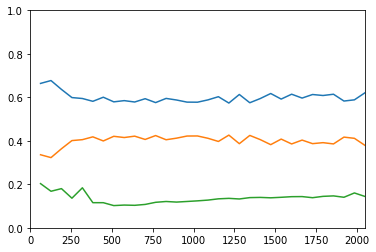

In [6]:
plt.xlim(0,np.max(Ls))
plt.ylim(0,1)
plt.plot(data[:,0],data[:,2])
plt.plot(data[:,0],data[:,3])
plt.plot(data[:,0],data[:,4])
plt.show()
plt.close()